# <center><b> Práctica 2 de Laboratorio 5 </b><br><u> Espectroscopía Láser </u></center>

Grupo 1: Trinidad Borrel, Bruno Sivilotti, Agustín Brusco

## Imports, formato y definiciones

In [1]:
import os
# Verificación y ubicación (y descarga de archivos en colab)
directory_path = os.getcwd()
folder_name = os.path.basename(directory_path)
if folder_name != 'Datos y código - Práctica 2':
    try:
        os.chdir("/content/Laboratorio_5_Datos/Datos y código - Práctica 2")
    except FileNotFoundError:
        !git clone https://github.com/agustinbrusco/Laboratorio_5_Datos.git
        os.chdir("/content/Laboratorio_5_Datos/Datos y código - Práctica 2")

import numpy as np
import scipy.constants as cte
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize  # Para el coloreo dinamico
# Formato para matplotlib
%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['figure.dpi'] = 100
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['axes.labelsize'] = 'large'
plt.rcParams['axes.xmargin'] = 0

# Diccionario de prefijos:
# si x_array contiene valores en V, (SCALE['m']*x_array) contiene valores en mV
SCALE = {'m': 1e3, 'μ': 1e6, 'n': 1e9, 'p': 1e12,
         'k': 1e-3, 'M': 1e-6, 'G': 1e-9, 'T': 1e-12}

def corriente_a_frecuencia(corriente: np.ndarray,
                           freqs_forzadas: np.ndarray,
                           corrientes_forzadas: np.ndarray,
                           ) -> np.ndarray:
    """Transforma un array de corrientes con las que se alimentó
    el láser en un array de frecuencias del haz emitido asumiendo
    una relacion de proporcionalidad inversa entre ambas cantidades
    (esto es, al mínimo valor de corriente queda asociado el máximo
    de frecuencia, y viceversa).
    """
    m = -((freqs_forzadas.max() - freqs_forzadas.min())
          / (corrientes_forzadas.max() - corrientes_forzadas.min()))
    return m*(corriente - corrientes_forzadas.min()) + freqs_forzadas.max()


def lineal(t, a, b):
    return a*t + b

## Frecuencias de Transición del $\mathrm{Rb}$

In [2]:
FREQS_RUBIDIO85 = np.array([3.61780000e+08, 3.03573244e+09, 3.77105833e+14, 3.77108868e+14, 3.77256703e+14, 3.77257968e+14, 3.77259738e+14])  # Hz
FREQS_RUBIDIO87 = np.array([8.14500000e+08, 6.83468261e+09, 3.77104391e+14, 3.77105206e+14, 3.77111226e+14, 3.88112040e+14])  # Hz
freqs_rubidio = np.sort(np.concatenate([FREQS_RUBIDIO85, FREQS_RUBIDIO87]))  # Hz
print(*[f"{f*SCALE['G']:.6g} GHz" for f in freqs_rubidio], sep=', ')

0.36178 GHz, 0.8145 GHz, 3.03573 GHz, 6.83468 GHz, 377104 GHz, 377105 GHz, 377106 GHz, 377109 GHz, 377111 GHz, 377257 GHz, 377258 GHz, 377260 GHz, 388112 GHz


## Carga de Mediciones
Ignoramos la lectura de las mediciones a 23,75 °C por la falta de picos identificables.

In [3]:
Temps_arr = np.arange(21.25, 23.75, 0.25)  # °C

# Mediciones sin imán:
times_arr = np.zeros((Temps_arr.size, 2500))  # s
# El 2500 se debe a la cantidad de mediciones que realiza el osciloscopio.
V1 = np.zeros_like(times_arr)  # V
V2 = np.zeros_like(times_arr)  # V

# Mediciones con imán:
times_mag_arr = np.zeros((Temps_arr.size, 2500))  # s
# El 2500 se debe a la cantidad de mediciones que realiza el osciloscopio.
V1_mag = np.zeros_like(times_mag_arr)  # V
V2_mag = np.zeros_like(times_mag_arr)  # V


for i, temp_tag in enumerate(Temps_arr):
    file = f'pendiente{int(temp_tag*100)}.npy'
    times_arr[i], V1[i], V2[i] = np.load(file)
    file_mag = f'magnet{int(temp_tag*100)}.npy'
    times_mag_arr[i], V1_mag[i], V2_mag[i] = np.load(file_mag)

Temps_arr = np.array([Temps_arr]*2500).T  # reshape por consistencia
# Así definidos, cada fila de cada array se corresponde a la misma medición (temperatura)

#Mediciones pitaya:
times_pitaya_arr = np.zeros((1, 1024))  # s
# El 2500 se debe a la cantidad de mediciones que realiza la red pitaya.
V1_pitaya = np.zeros_like(times_pitaya_arr)  # V
V2_pitaya = np.zeros_like(times_pitaya_arr)  # V
#cargo datos de pitaya
for i in range(1):
    file_pitaya = f'pitaya23_{i}.csv'
    times_pitaya_arr[i], V1_pitaya[i], _, V2_pitaya[i] = np.loadtxt(file_pitaya, skiprows=1, delimiter=",", unpack = True)

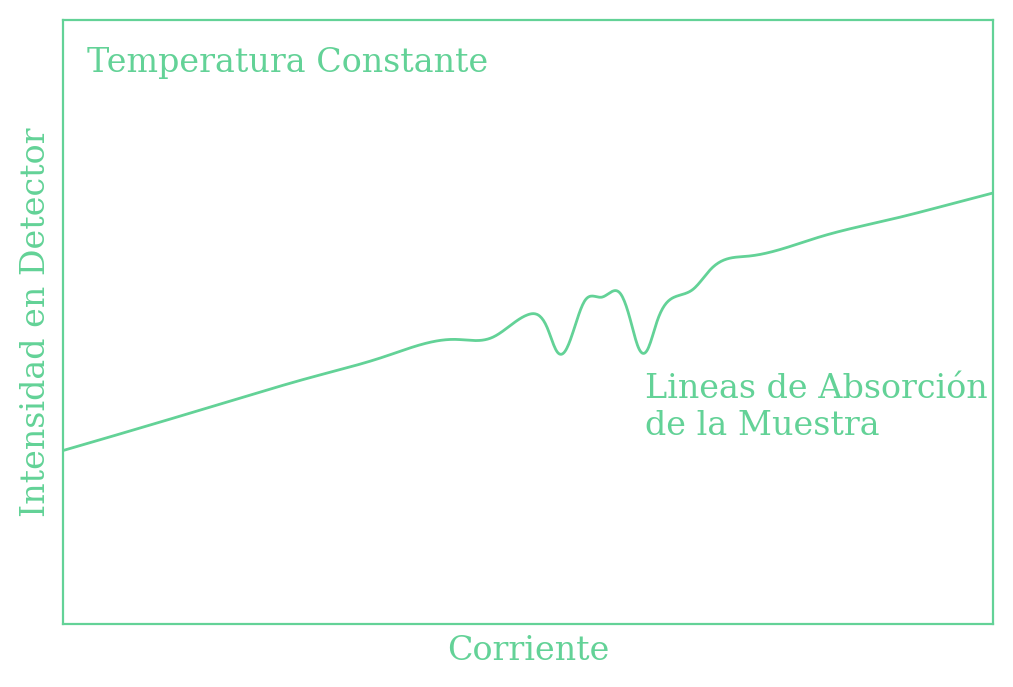

In [4]:
from scipy.interpolate import UnivariateSpline
f = UnivariateSpline(times_arr[5], V1[5], s=0.003)
fig, ax = plt.subplots(1, 1, )
plt.plot(times_arr[5], f(times_arr[5]), '-', c="#63d297", lw=1)
plt.text(-0.0021, -4e-2, "Lineas de Absorción\nde la Muestra", c="#63d297", size=12)
plt.text(-0.0045, 1e-1, "Temperatura Constante", c="#63d297", size=12)

ax.patch.set_alpha(0.)
for spine in ax.spines.values():
    spine.set_edgecolor('#63d297')
plt.xticks([])
ax.set_xmargin(-0.3)
plt.xlabel("Corriente", c="#63d297")
plt.yticks([])
plt.ylabel("Intensidad en Detector", c="#63d297")
plt.show()

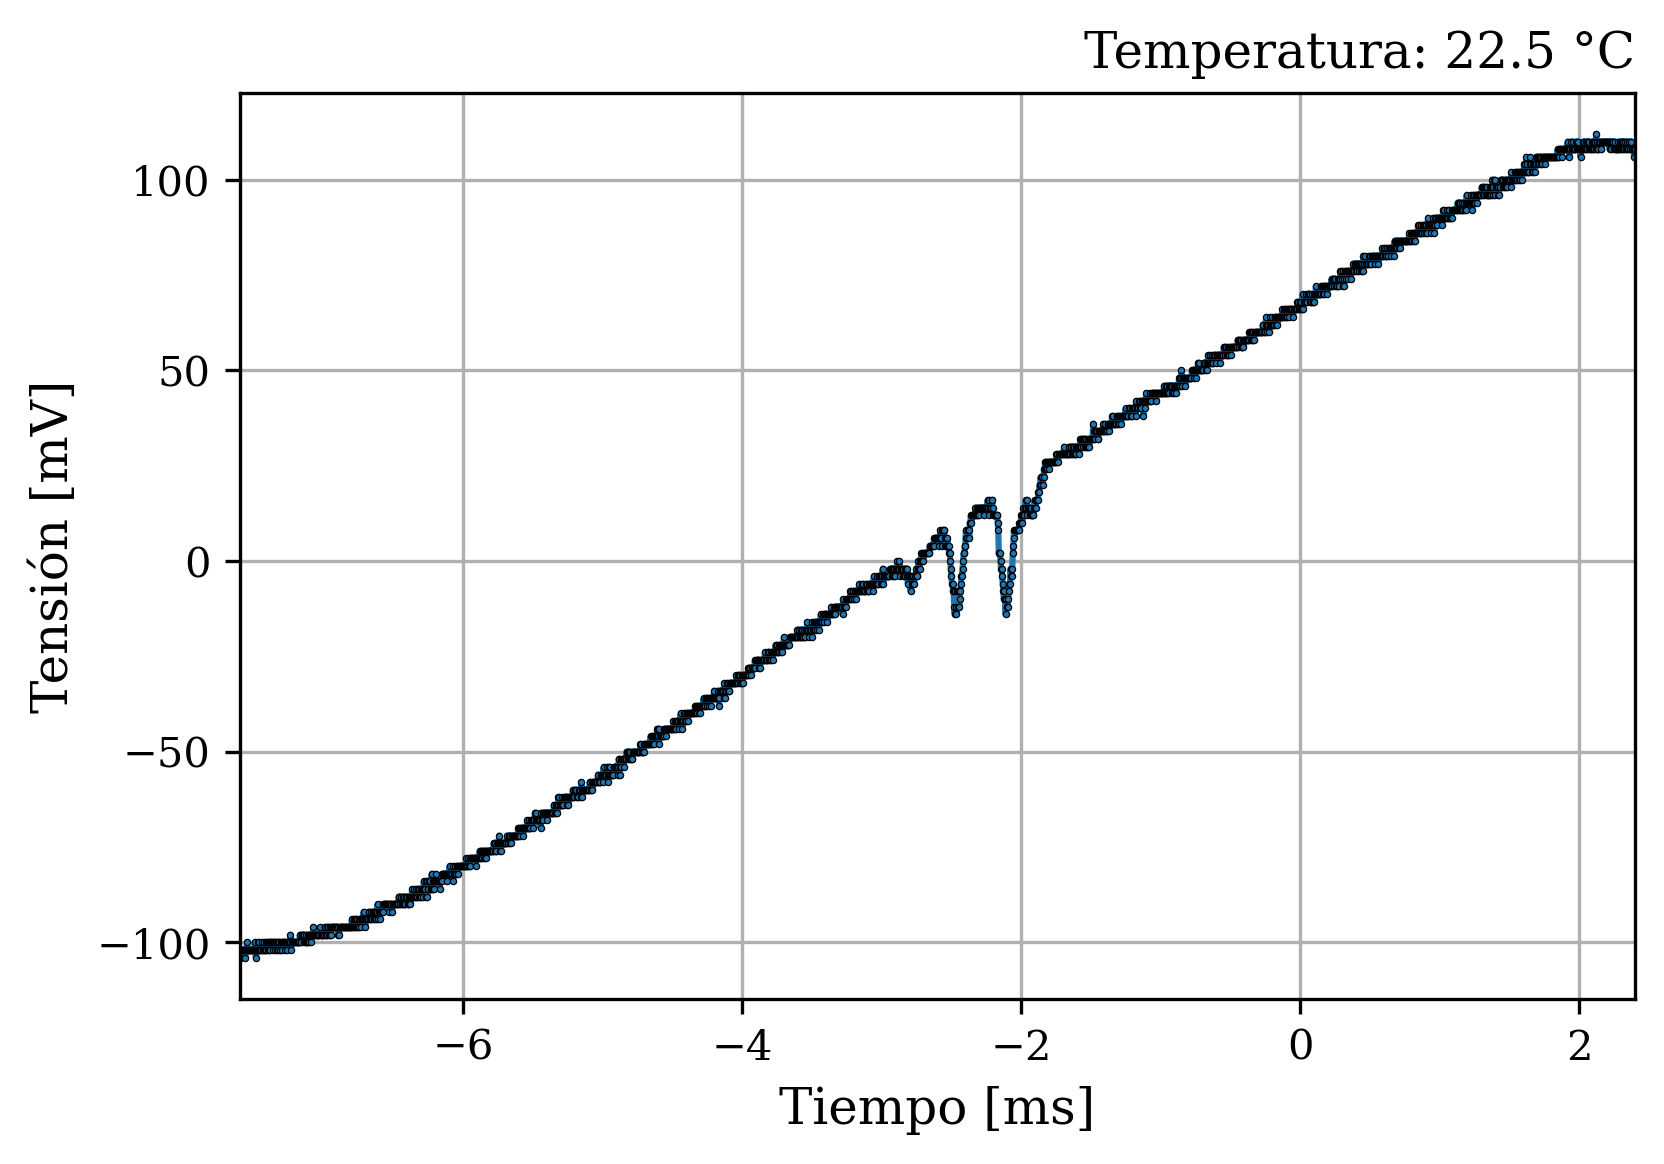

In [5]:
fig, ax = plt.subplots(1, 1, dpi=150)
ax.plot(times_arr[5]*1e3, V1[5]*1e3, ".-", mec='k', mew=0.3, ms=3)
ax.grid(True)
ax.set_xmargin(0)
ax.set_xlabel("Tiempo [ms]")
ax.set_ylabel("Tensión [mV]")
ax.set_title(f"Temperatura: {Temps_arr[5, 0]} °C", loc="right")
plt.show()

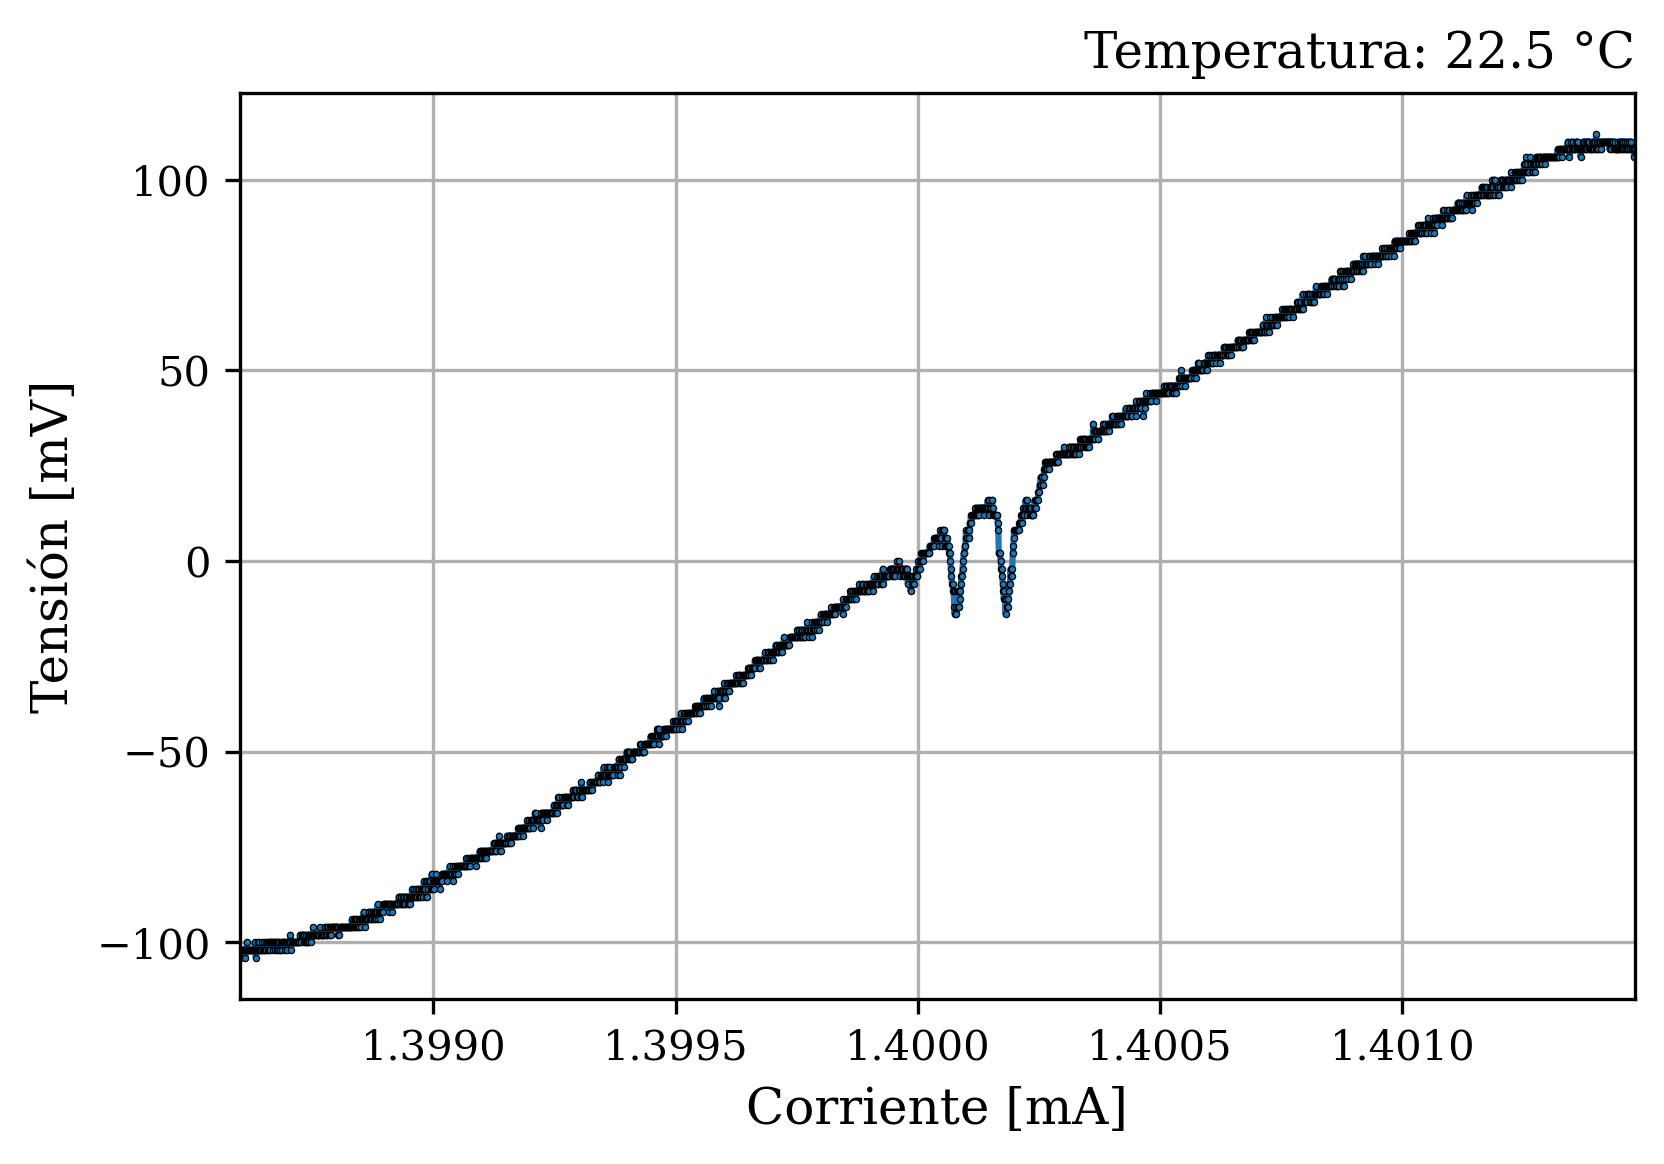

In [8]:
fig, ax = plt.subplots(1, 1, dpi=150)
ax.plot(corrientes_arr[5]*1e3, V1[5]*1e3, ".-", mec='k', mew=0.3, ms=3)
ax.grid(True)
ax.set_xmargin(0)
ax.set_xlabel("Corriente [mA]")
ax.set_ylabel("Tensión [mV]")
ax.set_title(f"Temperatura: {Temps_arr[5, 0]} °C", loc="right")
plt.show()

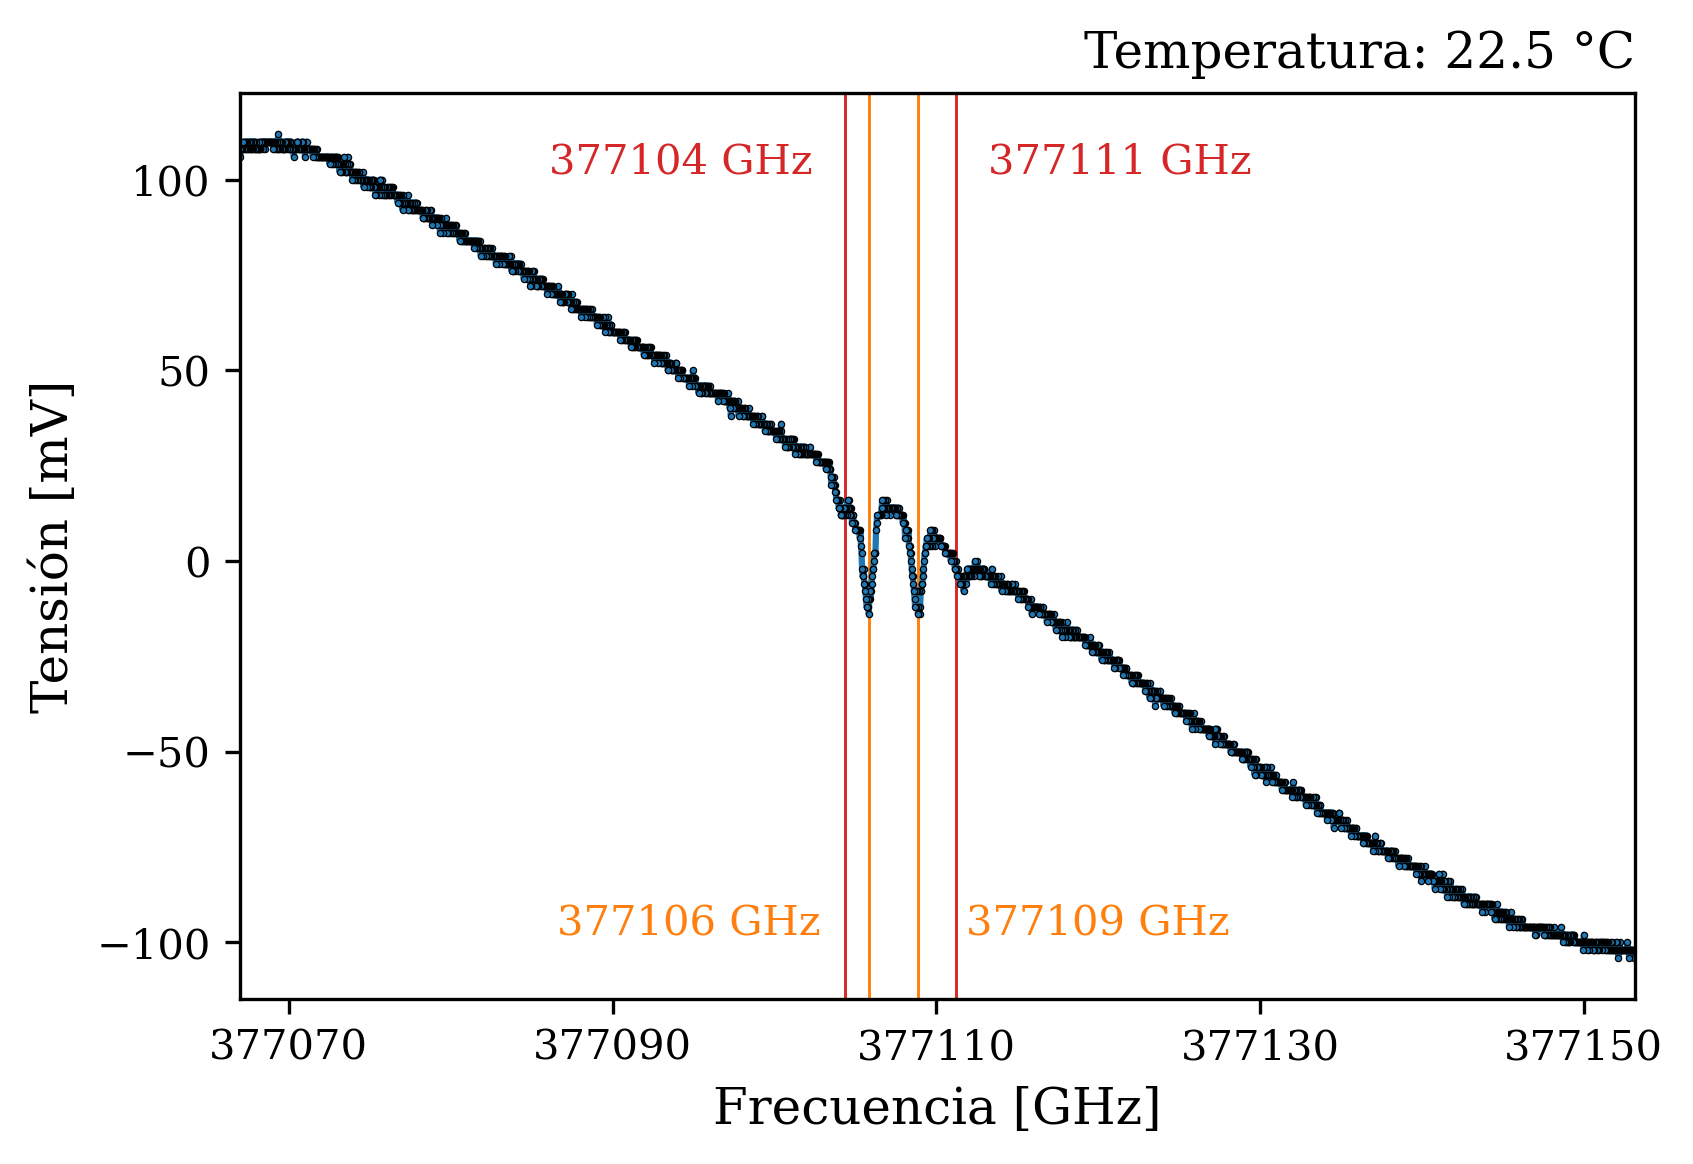

In [9]:
fig, ax = plt.subplots(1, 1, dpi=150)
ax.plot(freqs_arr[5]*SCALE[f_units], V1[5]*1e3, ".-", mec='k', mew=0.3, ms=3)
for rb_f, align, offset in zip(freqs_rubidio[[6, 7]], 
                       ["right", "left",], [-3, 3]):
    ax.axvline(rb_f*SCALE[f_units], ls='-', lw=0.7, c='C1', zorder=0)
    ax.text(rb_f*SCALE[f_units] + offset, -100,
            f"{rb_f*SCALE[f_units]:.0f} {f_units}Hz", c="C1",
            va="bottom", ha=align,
            rotation=0)
for rb_f, align, offset in zip(freqs_rubidio[[4, 8]], 
                       ["right", "left",], [-2, 2]):
    ax.axvline(rb_f*SCALE[f_units], ls='-', lw=0.7, c='C3', zorder=0)
    ax.text(rb_f*SCALE[f_units] + offset, 110,
            f"{rb_f*SCALE[f_units]:.0f} {f_units}Hz", c="C3",
            va="top", ha=align,
            rotation=0)

# ax.grid(True)

ax.set_xticks(ax.get_xticks()[1::2])
ax.set_xmargin(0)
ax.set_xlabel(f"Frecuencia [{f_units}Hz]")
ax.set_ylabel("Tensión [mV]")
ax.set_title(f"Temperatura: {Temps_arr[5, 0]} °C", loc="right")
plt.show()

## Transformación Tiempo -> Corriente -> Frecuencia

In [ ]:
# %matplotlib inline
v_units = 'm'
f_units = 'G'
freqs_arr = np.zeros_like(times_arr)  # Hz
freqs_mag_arr = np.zeros_like(times_arr)  # Hz
corrientes_arr = np.zeros_like(times_arr)  # A
peaks = [0,]*times_arr.shape[0]  # Indices
# Hipotesis: los extremos de tensión se asocian a los picos de corriente
corriente_setpoint = 1.4e-3  # A : Valor medio de las oscilaciones
corriente_depth = 0.1/100
corriente_max = corriente_setpoint*(1+corriente_depth)  # A
corriente_min = corriente_setpoint*(1-corriente_depth)  # A
corriente_rango = corriente_max - corriente_min  # A
for i, temp in enumerate(Temps_arr[:, 0]):
    # Para la medición sin imán:
    t_max = times_arr[i][np.argmax(V1[i])]  # s
    t_min = times_arr[i][np.argmin(V1[i])]  # s
    m = (corriente_max - corriente_min)/(t_max - t_min)  # A/s
    corrientes_arr[i] = m*(times_arr[i] - t_min) + corriente_min  # A
    popt, pcov = curve_fit(lineal, corrientes_arr[i], V1[i])
    # Para la medición con imán:
    t_mag_max = times_mag_arr[i][np.argmax(V1_mag[i])]  # s
    t_mag_min = times_mag_arr[i][np.argmin(V1_mag[i])]  # s
    m_mag = (corriente_max - corriente_min)/(t_mag_max - t_mag_min)  # A/s
    corrientes_mag = m_mag*(times_mag_arr[i] - t_mag_min) + corriente_min  # A

    peaks[i] = find_peaks(-(V1[i] - lineal(corrientes_arr[i], *popt)),
                          distance=30, prominence=0.01, height=0.015)[0]
    # Sabemos que estos corresponden com los picos que encontramos con find_peaks:
    idx1 = 6
    idx2 = 7
    freqs_arr[i] = corriente_a_frecuencia(corrientes_arr[i],
                                          freqs_rubidio[[idx1, idx2]],  # Hz
                                          corrientes_arr[i][peaks[i][[-2, -1]]])  # A
    
    freqs_mag_arr[i] = corriente_a_frecuencia(corrientes_mag,
                                              freqs_rubidio[[idx1, idx2]],  # Hz
                                              corrientes_arr[i][peaks[i][[-2, -1]]])  # A
    # Plots:
    plt.figure()
    plt.plot(SCALE[f_units]*freqs_arr[i],
             SCALE[v_units]*V1[i],
             '.-', ms=3, mec='k', mew=0.25,
             zorder=7, label="Sin Imán")
    plt.plot(SCALE[f_units]*freqs_mag_arr[i],
             SCALE[v_units]*V1_mag[i],
             'r.-', ms=3, mec='k', mew=0.25,
             zorder=8, label="Con Imán 1")
    plt.plot(SCALE[f_units]*freqs_mag_arr[i],
             SCALE[v_units]*V2_mag[i],
             'm.-', ms=3, mec='k', mew=0.25,
             zorder=8, label="Con Imán 2")
    plt.plot(SCALE[f_units]*freqs_arr[i][peaks[i]],
             SCALE[v_units]*V1[i][peaks[i]],
             '^', mec='k', mew=0.25, zorder=10)
    plt.axvline(SCALE[f_units]*freqs_arr[i][peaks[i][-1]],
                ls='--', c='C0', zorder=4)
    plt.axvline(SCALE[f_units]*freqs_arr[i][peaks[i][-2]],
                ls='--', c='C0', zorder=4)
    plt.grid(True)
    plt.legend(title=f"Temperatura: {temp} °C")
    plt.ylabel(f"Voltaje [{v_units}V]")
    plt.xlim(SCALE[f_units]*freqs_arr[i][peaks[i][-1]] -10 , SCALE[f_units]*freqs_arr[i][peaks[i][-2]]+10 )
    plt.xlabel(f"Frecuencia [{f_units}Hz]")
    plt.show()

peaks = np.array(peaks)

### Renormalización señales osciloscopio

In [ ]:
#renormalizo Osciloscopio:
V1_norm = np.zeros_like(V1_mag)
V2_norm = np.zeros_like(V2_mag)
offset_1 = 0
offset_2 = 0

for i, temp in enumerate(Temps_arr[:, 0]):
    offset_1 = (np.max(V1_mag[i])+np.min(V1_mag[i]))/2
    offset_2 = (np.max(V2_mag[i])+np.min(V2_mag[i]))/2
    V1_norm[i] = V1_mag[i]-offset_1
    V1_norm[i] = V1_norm[i]/np.max(V1_norm[i])
    V2_norm[i] = V2_mag[i]-offset_2
    V2_norm[i] = V2_norm[i]/np.max(V2_norm[i])
    # print(np.max(V1_norm[i]))
    # print(np.min(V1_norm[i]))
    plt.figure()
    plt.plot(SCALE[f_units]*freqs_arr[i],
             V1_norm[i],
             '.-', ms=3, mec='k', mew=0.25,
             zorder=7, label="V1")
    plt.plot(SCALE[f_units]*freqs_arr[i],
             V2_norm[i],
             '.-', ms=3, mec='k', mew=0.25,
             zorder=7, label="V2")
    plt.grid()
    plt.legend(title=f"Temperatura: {temp} °C")
    plt.ylabel(f"Señal")
    plt.xlabel(f"Frecuencia [{f_units}Hz]")
    plt.show()

## Señales DAVS

### Davs osciloscopio

In [ ]:
Davs_arr = np.zeros_like(times_arr)

for i, temp in enumerate(Temps_arr[:, 0]):
    Davs_arr[i] = V1[i]-V2[i]
    plt.figure()
    plt.plot(SCALE[f_units]*freqs_arr[i],
             SCALE[v_units]*Davs_arr[i],
             '.-', ms=3, mec='k', mew=0.25,
             zorder=7, label="Davs")
    plt.legend(title=f"Temperatura: {temp} °C")
    plt.ylabel(f"Voltaje [{v_units}V]")
    plt.xlim(SCALE[f_units]*freqs_arr[i][peaks[i][-1]]-10,
             SCALE[f_units]*freqs_arr[i][peaks[i][-2]]+10)
    plt.xlabel(f"Frecuencia [{f_units}Hz]")
    plt.show()

### Davs osciloscopio con imán

In [ ]:
Davs_arr = np.zeros_like(times_arr)

for i, temp in enumerate(Temps_arr[:, 0]):
    Davs_arr[i] = V1_mag[i]-V2_mag[i]
    plt.figure()
    plt.plot(SCALE[f_units]*freqs_arr[i],
             SCALE[v_units]*Davs_arr[i],
             '.-', ms=3, mec='k', mew=0.25,
             zorder=7, label="Davs")
    plt.legend(title=f"Temperatura: {temp} °C")
    plt.ylabel(f"Voltaje [{v_units}V]")
    plt.xlim(SCALE[f_units]*freqs_arr[i][peaks[i][-1]]-10,
             SCALE[f_units]*freqs_arr[i][peaks[i][-2]]+10 )
    plt.xlabel(f"Frecuencia [{f_units}Hz]")
    plt.show()

### Renormalizo pitaya

In [ ]:
#renormalizo pitaya:
V1_norm = np.zeros_like(V1_pitaya)
V2_norm = np.zeros_like(V2_pitaya)

for i in range(2):
    offset_1 = (np.max(V1_pitaya[i])+np.min(V1_pitaya[i]))/2
    offset_2 = (np.max(V2_pitaya[i])+np.min(V2_pitaya[i]))/2
    V1_norm[i] = V1_pitaya[i]-offset_1
    V1_norm[i] = V1_norm[i]/np.max(V1_norm[i])
    V2_norm[i] = V2_pitaya[i]-offset_2
    V2_norm[i] = V2_norm[i]/np.max(V2_norm[i])
    plt.figure()
    plt.plot(times_pitaya_arr[i],
             V1_norm[i],
             '.-', ms=3, mec='k', mew=0.25,
             zorder=7, label="V1")
    plt.plot(times_pitaya_arr[i],
             V2_norm[i],
            '.-', ms=3, mec='k', mew=0.25,
             zorder=7, label="V2")
    plt.plot(times_pitaya_arr[i],
             (V1_norm[i]-V2_norm[i]),
             '.-', ms=3, mec='k', mew=0.25,
             zorder=7, label="V1-V2")
    plt.ylabel(f"Señal")
    plt.legend()
    plt.xlabel(f"Tiempo [s]")
    plt.show()

### Davs Pitaya

In [ ]:
Davs_arr = np.zeros_like(times_pitaya_arr)

for i in range(2):
    Davs_arr[i] = V1_norm[i]-V2_norm[i]
    plt.figure()
    plt.plot(times_pitaya_arr[i],
             SCALE[v_units]*Davs_arr[i],
             '.-', ms=3, mec='k', mew=0.25,
             zorder=7, label="Davs")
    plt.ylabel(f"Voltaje [{v_units}V]")
    #plt.xlim(SCALE[f_units]*freqs_arr[i][peaks[i][-1]] -10 , SCALE[f_units]*freqs_arr[i][peaks[i][-2]]+10 )
    plt.xlabel(f"Tiempo [s]")
    plt.show()

## Superficie Corriente, Frecuencia, Temperatura

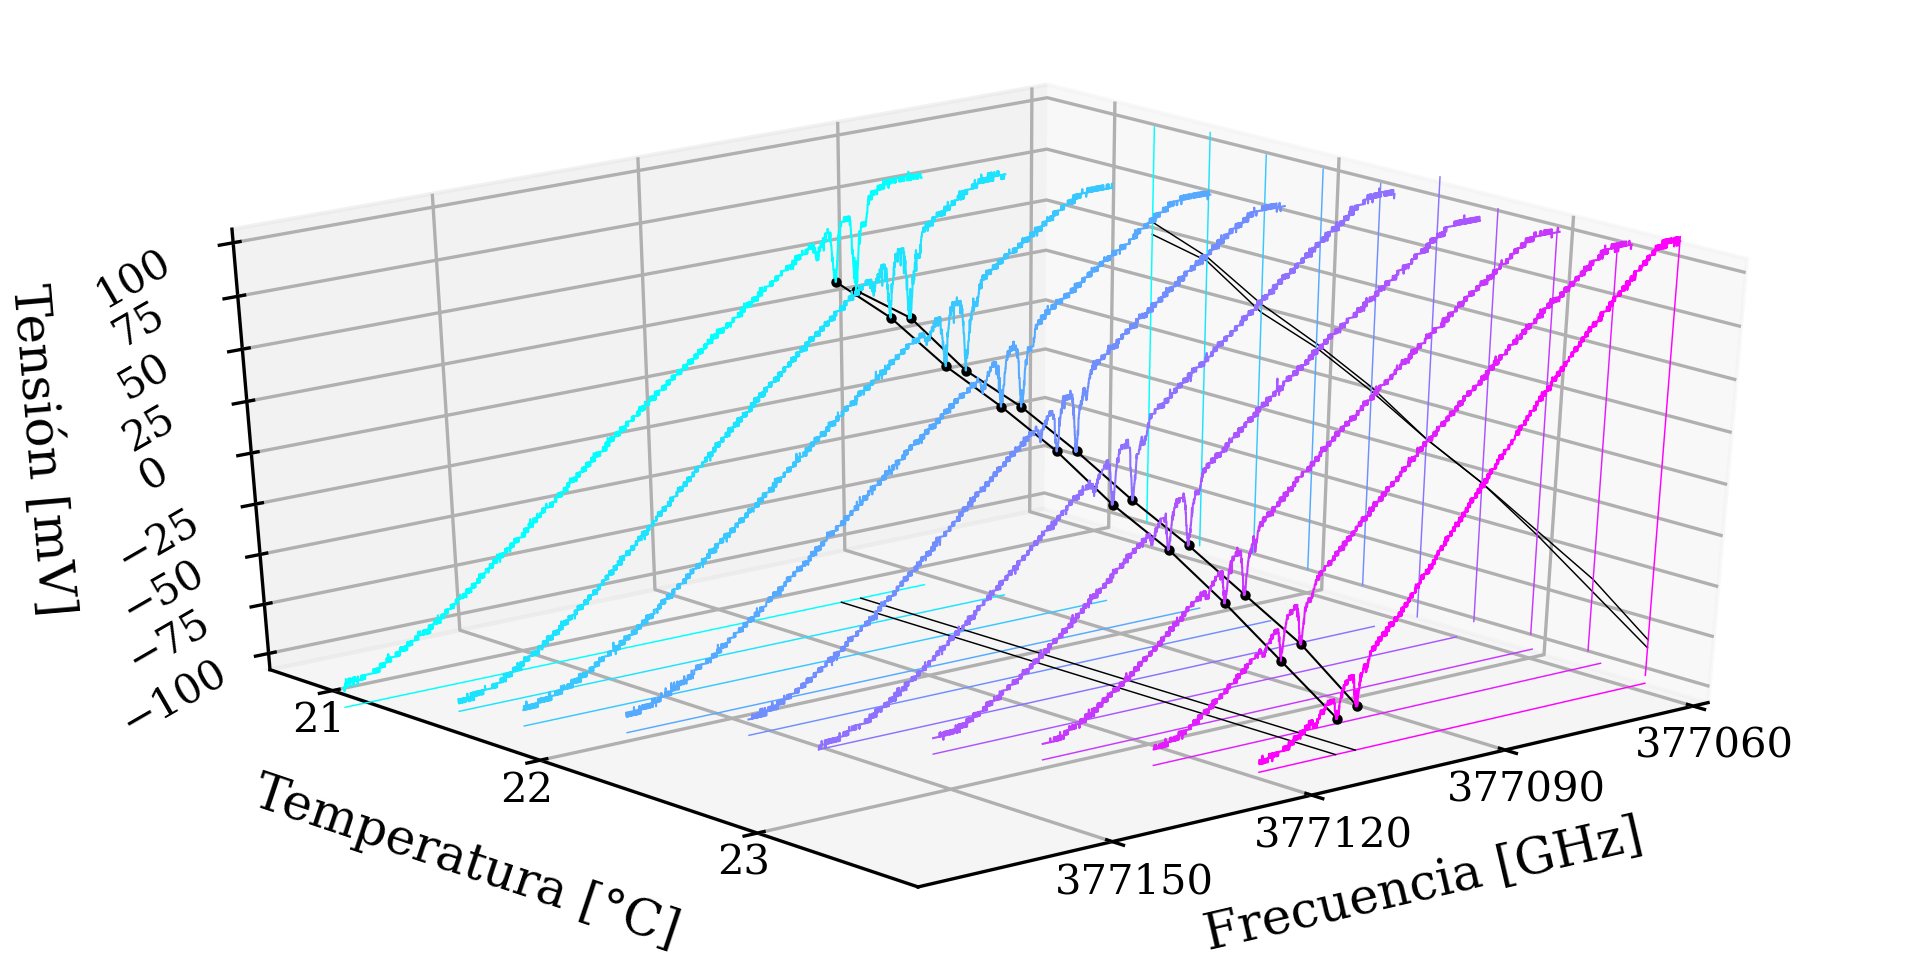

In [23]:
# DESCOMENTAR SI SE CORRE LOCALMENTE PARA VENTANA INTERACTIVA
# %matplotlib inline
norm = Normalize(Temps_arr.min(), Temps_arr.max())  # Un normalizador que asocia valores del intervalo de n al rango [0:1].
coolscale = plt.cm.ScalarMappable(norm, 'cool', )  # Asocio los valores del rango de n normalizado en [0:1] a una paleta de colores.
colors1 = coolscale.to_rgba  # la función que dado n devuelve el color asociado
warmscale = plt.cm.ScalarMappable(norm, 'inferno', )  # Asocio los valores del rango de n normalizado en [0:1] a una paleta de colores.
colors2 = warmscale.to_rgba  # la función que dado n devuelve el color asociado


v_units = 'm'
f_units = 'G'
V_floor = SCALE[v_units]*V1.min()
V_ceil = SCALE[v_units]*V1.max()
fig = plt.figure(figsize=(8, 4), dpi=150)
ax = fig.add_subplot(projection='3d')


# Grafico de los puntos que usamos para calibrar:
plt.plot(SCALE[f_units]*freqs_rubidio[[6,]*10],
         Temps_arr[:, 0],
         SCALE[v_units]*np.diag(V1[:, peaks.T[1]]),
         'k.-', ms=3, lw=0.5)
plt.plot([377060,]*10,
         Temps_arr[:, 0],
         SCALE[v_units]*np.diag(V1[:, peaks.T[1]]),
         'k-', ms=3, lw=0.35, zorder=0)
plt.plot(SCALE[f_units]*freqs_rubidio[[6,]*2],
         [21.25, 23.5],
         [V_floor, ]*2,
         'k-', ms=3, lw=0.35)
plt.plot(SCALE[f_units]*freqs_rubidio[[7,]*10],
         Temps_arr[:, 0],
         SCALE[v_units]*np.diag(V1[:, peaks.T[0]]),
         'k.-', ms=3, lw=0.5)
plt.plot([377060,]*10,
         Temps_arr[:, 0],
         SCALE[v_units]*np.diag(V1[:, peaks.T[0]]),
         'k-', ms=3, lw=0.35, zorder=0)
plt.plot(SCALE[f_units]*freqs_rubidio[[7,]*2],
         [21.25, 23.5],
         [V_floor, ]*2,
         'k-', ms=3, lw=0.35)

# Superficie definida por las mediciones:
# ax.plot_surface(SCALE[f_units]*freqs_arr,
#                 Temps_arr,
#                 SCALE[v_units]*V1,
#                 color='C1', alpha=0.25)
# ax.contour(SCALE[f_units]*freqs_arr,
#            Temps_arr,
#            SCALE[v_units]*V1,
#            zdir='y', offset=21., cmap="cool", linewidths=0.35)

# Curvas medidas sin imán:
for f, t, v in zip(SCALE[f_units]*freqs_arr[::-1],
                   Temps_arr[::-1],
                   SCALE[v_units]*V1[::-1]):
    ax.plot(f, t, v, c=colors1(t[0]), lw=0.5)
    ax.plot([f.min(), f.max()], t[:2], [V_floor, V_floor], c=colors1(t[0]), lw=0.35, zorder=0)
    ax.plot([377060, 377060], t[:2], [v.min(), v.max()], c=colors1(t[0]), lw=0.35, zorder=0)

# # Curvas medidas con imán:
# for f, t, v in zip(SCALE[f_units]*freqs_mag_arr[::-1],
#                    Temps_arr[::-1],
#                    SCALE[v_units]*V1_mag[::-1]):
#     ax.plot(f, t, v, c=colors2(t[0]), ls='--', lw=0.5, alpha=0.5)

ax.set_xticks(np.arange(377060, 377180, 30))
ax.tick_params('x', pad=-2.5, rotation=0,)
ax.set_xlim(377060, 377176)
ax.set_xlabel(f"Frecuencia [{f_units}Hz]")

ax.set_yticks(np.arange(21, 24))
ax.tick_params('y', pad=-5., rotation=0,)
ax.set_ylim(20.75, 23.65)
ax.set_ylabel("Temperatura [°C]")

ax.set_zlim(V_floor, V_ceil-10)
ax.tick_params('z', labelrotation=30)
ax.set_zlabel(f"Tensión [{v_units}V]",)

ax.view_init(elev=30, azim=50)
plt.show()

# %matplotlib inline

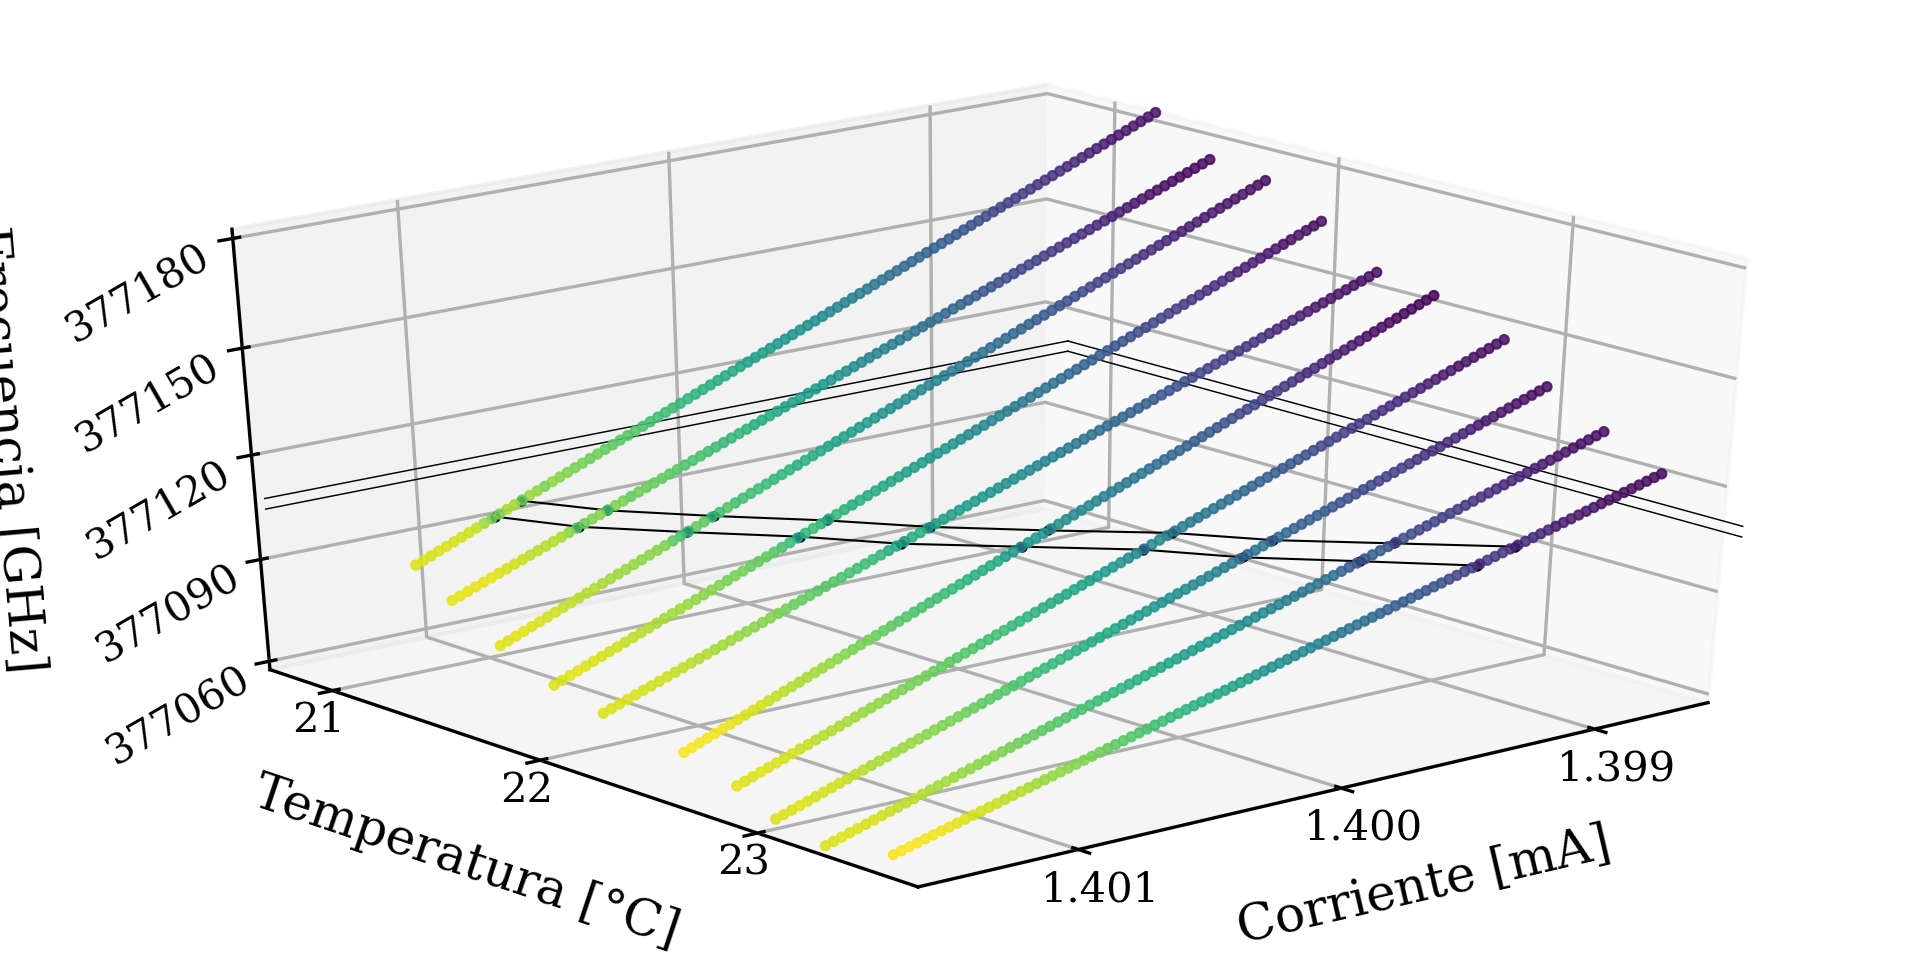

In [18]:
# DESCOMENTAR SI SE CORRE LOCALMENTE PARA VENTANA INTERACTIVA
# %matplotlib inline
from sympy import rotations


norm = Normalize(V1.min(), V1.max())  # Un normalizador que asocia valores del intervalo de n al rango [0:1].
voltscale = plt.cm.ScalarMappable(norm, 'viridis', )  # Asocio los valores del rango de n normalizado en [0:1] a una paleta de colores.
colorsV = voltscale.to_rgba  # la función que dado n devuelve el color asociado



i_units = 'm'
f_units = 'G'

fig = plt.figure(figsize=(8, 4), dpi=150)
ax = fig.add_subplot(projection='3d')

plt.plot(SCALE[i_units]*np.diag(corrientes_arr[:, peaks.T[1]]),
         Temps_arr[:, 0],
         SCALE[f_units]*freqs_rubidio[[6,]*10],
         'k.-', ms=3, lw=0.5)
plt.plot([1.3985, 1.3985],
         [20.75, 23.75],
         SCALE[f_units]*freqs_rubidio[[6,]*2],
         'k-', ms=3, lw=0.35,zorder=0)
plt.plot([1.3985, 1.4016],
         [20.75, 20.75],
         SCALE[f_units]*freqs_rubidio[[6,]*2],
         'k-', ms=3, lw=0.35,zorder=0)
plt.plot(SCALE[i_units]*np.diag(corrientes_arr[:, peaks.T[0]]),
         Temps_arr[:, 0],
         SCALE[f_units]*freqs_rubidio[[7,]*10],
         'k.-', ms=3, lw=0.5)
plt.plot([1.3985, 1.3985],
         [20.75, 23.75],
         SCALE[f_units]*freqs_rubidio[[7,]*2],
         'k-', ms=3, lw=0.35,zorder=0)
plt.plot([1.3985, 1.4016],
         [20.75, 20.75],
         SCALE[f_units]*freqs_rubidio[[7,]*2],
         'k-', ms=3, lw=0.35,zorder=0)

# Superficie definida por las mediciones:
# ax.plot_surface(SCALE[i_units]*corrientes_arr,
#                 Temps_arr,
#                 SCALE[f_units]*freqs_arr,
#                 color='C1', alpha=0.25, zorder=3)

# Curvas medidas sin imán:
for i, t, f, v in zip(SCALE[i_units]*corrientes_arr[::-1],
                      Temps_arr[::-1],
                      SCALE[f_units]*freqs_arr[::-1],
                      V1[::-1]):
    ax.scatter3D(i[::25], t[::25], f[::25], c=colorsV(v[::25]), s=5, lw=0.5, zorder=10,
                 alpha=0.85)


ax.set_xticks(np.arange(1.399, 1.4015, 0.0010))
ax.tick_params('x', pad=-2.5, rotation=0)
ax.set_xlim(1.3986, 1.40153)
ax.set_xlabel(f"Corriente [{i_units}A]")

ax.set_yticks(np.arange(21, 24))
ax.tick_params('y', pad=-5., rotation=0,)
ax.set_ylim(20.75, 23.65)
ax.set_ylabel("Temperatura [°C]")

ax.set_zticks(np.arange(377060, 377190, 30))
ax.tick_params('z', pad=3, rotation=30,)
ax.set_zlim(377060, 377180)
ax.set_zlabel(f"Frecuencia [{f_units}Hz]", labelpad=8)

ax.view_init(elev=30, azim=50)
plt.show()

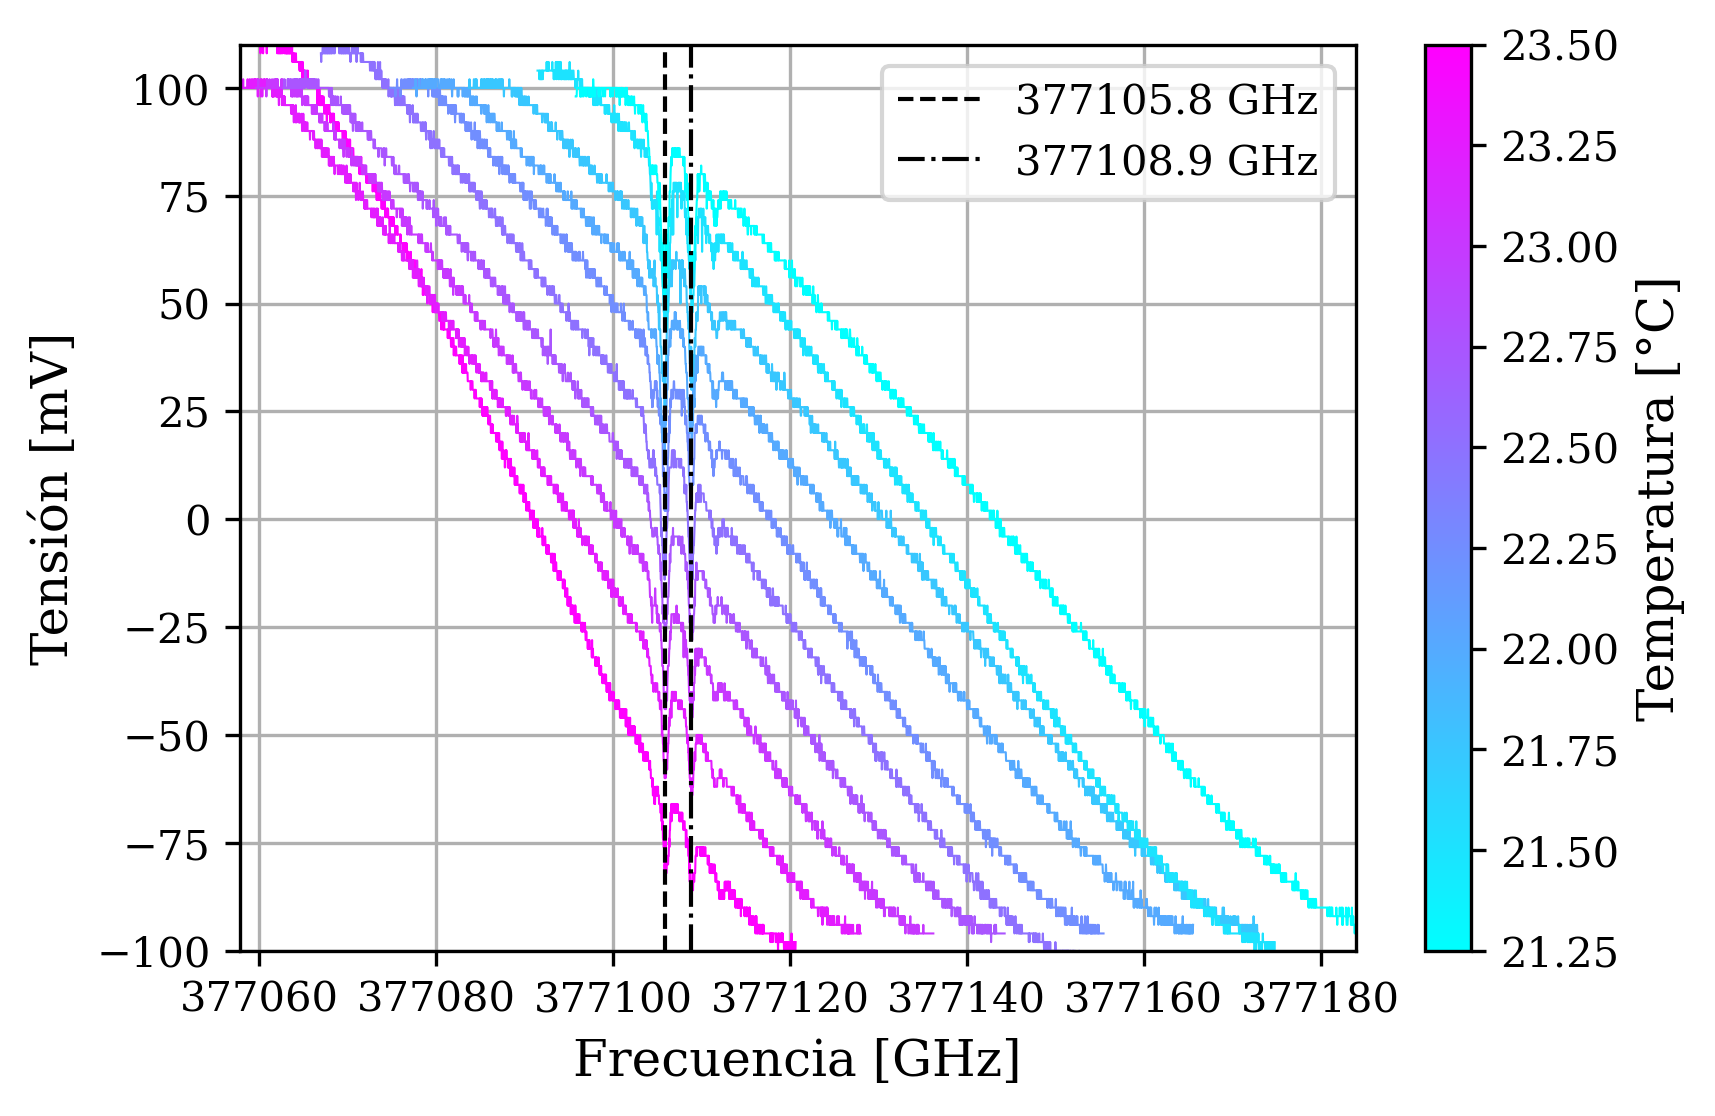

In [51]:
fig, ax = plt.subplots(1, 1, dpi=150)

# Curvas medidas sin imán:
for f, t, v in zip(SCALE[f_units]*freqs_arr[::-1],
                   Temps_arr[::-1],
                   SCALE[v_units]*V1[::-1]):
    ax.plot(f, v, c=colors1(t[0]), lw=0.5)
    
plt.axvline(SCALE[f_units]*freqs_rubidio[[6]],
                ls='--', lw = 1, c='black', label=f"{np.round(freqs_rubidio[[6]][0]*SCALE[f_units],1)} {f_units}Hz")
plt.axvline(SCALE[f_units]*freqs_rubidio[[7]],
                ls='-.', lw = 1, c='black', label=f"{np.round(freqs_rubidio[[7]][0]*SCALE[f_units],1)} {f_units}Hz")
plt.legend()
plt.xlabel(f"Frecuencia [{f_units}Hz]")
plt.colorbar(coolscale, label="Temperatura [°C]")
plt.ylabel(f"Tensión [{v_units}V]",)
plt.ylim(-100,110)
plt.grid()
plt.show()

# %matplotlib inline

## Cálculo del Ancho de los picos

In [37]:
from scipy.interpolate import interp1d
from scipy import signal 

def lineal(x, a, b):
    return x*a + b

def ancho_pico(freqs_, volts_, peaks_, n_):
    freqs = freqs_[n_]
    volts = volts_[n_]
    peaks = peaks_[n_]

    #Elimino tendencia lineal tomando los puntos extremos sobre la región donde estan los picos de absorción
    m = (volts[peaks[0]- 150] - volts[peaks[1]+150] )/(freqs[peaks[0]-150] - freqs[peaks[1]+150] )
    b = volts[peaks[0] - 150] - m*freqs[peaks[0] - 150]
    y = lineal(freqs, m, b)

    plt.title(f'Temperatura {Temps_arr[n_][0]}°C, Eliminación Tendencia Lineal y Aplicación Filtro')
    plt.plot(SCALE[f_units]*freqs[peaks[0]-150: peaks[1]+150], SCALE[v_units]*volts[peaks[0]-150: peaks[1]+150], '.--', lw=1, mec='k', mew=0.75)
    plt.plot(SCALE[f_units]*freqs[peaks[0]-150: peaks[1]+150], SCALE[v_units]*y[peaks[0]-150: peaks[1]+150], '.--', lw=1, mec='k', mew=0.75)
    plt.xlabel(f'Frecuencia [{f_units}Hz]')
    plt.ylabel(f'Voltaje [{v_units}V]')
    plt.grid()
    plt.legend()
    plt.show()    

    volts = volts - y


    #Aplico Filtro Savitzky-Golay
    volts = signal.savgol_filter(volts, window_length=11, polyorder=3, mode="nearest")

    #Grafico señal tuneada
    plt.title(f'Temperatura {Temps_arr[n_][0]}°C, Eliminación Tendencia Lineal y Aplicación Filtro')
    plt.plot(SCALE[f_units]*freqs[peaks[0]-150: peaks[1]+150], SCALE[v_units]*volts[peaks[0]-150: peaks[1]+150], '.--', lw=1, mec='k', mew=0.75)
    plt.xlabel(f'Frecuencia [{f_units}Hz]')
    plt.ylabel(f'Voltaje [{v_units}V]')
    plt.grid()
    plt.legend()
    plt.show()    

    ancho = []

    for i in range(len(peaks)):
        print(f'\nResultados: Temperatura n°{Temps_arr[n_][0]}°C y Pico n°{i} \n')
        #Me acerco a la zona del pico i esimo
        f =  freqs[peaks[i]-50:peaks[i]+50] 
        v = volts[peaks[i]-50: peaks[i]+50]

        #Busco la mitad de altura del gráfico, para calcular su ancho
        #altura_media = (np.max(v)+np.min(v))/2 
        altura_media = (np.min(v))/2 
        print(f'La altura_media es de {altura_media*SCALE[v_units]} {v_units}V')

        #Interpolo 
        frecuencia_interp = np.linspace( np.min(f), np.max(f), 100*len(f))
        interp = (interp1d(f, v-altura_media, kind='cubic'))  #Desplazo el grafico tal que la altura media queda en y = 0
        interp_ = interp(frecuencia_interp)

        #Busco Raices
        roots=[]
        for j in range(len(interp_)):
            if np.abs(interp_[j])<0.00005:
                roots.append(frecuencia_interp[j])


        idx_max_dif = np.abs(roots[0] - roots).argmax()
        alpha = np.abs(roots[0] - roots[idx_max_dif])
        print(f'El ancho es de {SCALE[f_units]*alpha} {f_units}Hz')
        ancho.append(SCALE[f_units]*alpha)

        plt.title(f'Temperatura {Temps_arr[n_][0]}°C, Pico n°{i}')
        plt.plot(SCALE[f_units]*f, SCALE[v_units]*v, '.--', lw=1, mec='k', mew=0.75)
        plt.axhline(SCALE[v_units]*altura_media, ls='--', c='red', zorder=4, label='Altura media')
        plt.axhline(SCALE[v_units]*np.max(v), ls='--', c='C0', zorder=4)
        plt.axhline(SCALE[v_units]*np.min(v), ls='--', c='C0', zorder=4)
        plt.xlabel(f'Frecuencia [{f_units}Hz]')
        plt.ylabel(f'Voltaje [{v_units}V]')
        plt.grid()
        plt.legend()
        plt.show()

        plt.title(f'Interpolación: Temperatura {Temps_arr[n_][0]}°C, Pico n°{i}')
        plt.plot(SCALE[f_units]*frecuencia_interp, interp_*SCALE[v_units],
                 c="C1", label='Interpolación')
        plt.plot(SCALE[f_units]*f, (v-altura_media)*SCALE[v_units],
                 '.', c="C0", mec='k', mew=0.75,
                 label='Medición desplazada')
        plt.axvline(roots[0]*SCALE[f_units],ls='--', c='red', zorder=4, label='raíz 0')
        plt.axvline(roots[idx_max_dif]*SCALE[f_units],ls='--', c='red', zorder=4, label='raíz n')
        plt.xlabel(f'Frecuencia [{f_units}Hz]')
        plt.ylabel(f'Voltaje [{v_units}V]')
        plt.grid()
        plt.legend()
        plt.show()

    return ancho, freqs, volts, n_

In [38]:
#Misma función pero con tiempo

from scipy.interpolate import interp1d
from scipy import signal 

def lineal(x, a, b):
    return x*a + b

def ancho_pico_tiempo(time, volts_, peaks_, n_):
    time = time[n_]
    volts = volts_[n_]
    peaks = peaks_[n_]

    #Elimino tendencia lineal tomando los puntos extremos sobre la región donde estan los picos de absorción
    m = (volts[peaks[0]- 150] - volts[peaks[1]+150] )/(time[peaks[0]-150] - time[peaks[1]+150] )
    b = volts[peaks[0] - 150] - m*time[peaks[0] - 150]
    y = lineal(time, m, b)

    plt.title(f'Temperatura {n_}, Eliminación Tendencia Lineal y Aplicación Filtro')
    plt.plot(time[peaks[0]-150: peaks[1]+150], SCALE[v_units]*volts[peaks[0]-150: peaks[1]+150], '.--', lw=1, mec='k', mew=0.75)
    plt.plot(time[peaks[0]-150: peaks[1]+150], SCALE[v_units]*y[peaks[0]-150: peaks[1]+150], '.--', lw=1, mec='k', mew=0.75)
    plt.xlabel(f'Tiempo [s]')
    plt.ylabel(f'Voltaje [{v_units}V]')
    plt.grid()
    plt.legend()
    plt.show()    

    volts = volts - y


    #Aplico Filtro Savitzky-Golay
    volts = signal.savgol_filter(volts, window_length=11, polyorder=3, mode="nearest")

    #Grafico señal tuneada
    plt.title(f'Temperatura {n_}, Eliminación Tendencia Lineal y Aplicación Filtro')
    plt.plot(time[peaks[0]-150: peaks[1]+150], SCALE[v_units]*volts[peaks[0]-150: peaks[1]+150], '.--', lw=1, mec='k', mew=0.75)
    plt.xlabel(f'Tiempo [s]')
    plt.ylabel(f'Voltaje [{v_units}V]')
    plt.grid()
    plt.legend()
    plt.show()    

    ancho = []

    for i in range(len(peaks)):
        print(f'\nResultados: Temperatura n°{n_} y Pico n°{i} \n')
        #Me acerco a la zona del pico i esimo
        t =  time[peaks[i]-50:peaks[i]+50] 
        v = volts[peaks[i]-50: peaks[i]+50]

        #Busco la mitad de altura del gráfico, para calcular su ancho
        #altura_media = (np.max(v)+np.min(v))/2 
        altura_media = (np.min(v))/2 
        print(f'La altura_media es de {altura_media*SCALE[v_units]} {v_units}V')

        #Interpolo 
        tiempo_interp = np.linspace( np.min(t), np.max(t), 100*len(t))
        interp = (interp1d(t, v-altura_media, kind='cubic'))  #Desplazo el grafico tal que la altura media queda en y = 0
        interp_ = interp(tiempo_interp)

        #Busco Raices
        roots=[]
        for j in range(len(interp_)):
            if np.abs(interp_[j])<0.00005:
                roots.append(tiempo_interp[j])


        idx_max_dif = np.abs(roots[0] - roots).argmax()
        alpha = np.abs(roots[0] - roots[idx_max_dif])
        print(f'El ancho es de {alpha} s')
        ancho.append(alpha)

        plt.title(f'Temperatura {Temps_arr[n_][0]}°, Pico n°{i}')
        plt.plot(t, SCALE[v_units]*v, '.--', lw=1, mec='k', mew=0.75)
        plt.axhline(SCALE[v_units]*altura_media, ls='--', c='red', zorder=4, label='Altura media')
        plt.axhline(SCALE[v_units]*np.max(v), ls='--', c='C0', zorder=4)
        plt.axhline(SCALE[v_units]*np.min(v), ls='--', c='C0', zorder=4)
        plt.xlabel(f'Tiempo [s]')
        plt.ylabel(f'Voltaje [{v_units}V]')
        plt.grid()
        plt.legend()
        plt.show()

        plt.title(f'Interpolación: Temperatura {Temps_arr[n_][0]}°, Pico n°{i}')
        plt.plot(tiempo_interp, interp_*SCALE[v_units],
                 c="C1", label='Interpolación')
        plt.plot(t, (v-altura_media)*SCALE[v_units],
                 '.', c="C0", mec='k', mew=0.75,
                 label='Medición desplazada')
        plt.axvline(roots[0],ls='--', c='red', zorder=4, label='raíz 0')
        plt.axvline(roots[idx_max_dif],ls='--', c='red', zorder=4, label='raíz n')
        plt.xlabel(f'Tiempo [s]')
        plt.ylabel(f'Voltaje [{v_units}V]')
        plt.grid()
        plt.legend()
        plt.show()

    return ancho, time, volts, n_

In [ ]:
anchos_tiempo = [] #GHz
t_ = []
v_ = []
i_ = []
for i in range(len(times_arr)):
    a, t, v, i = ancho_pico_tiempo(times_arr, V1, peaks, i)
    t_.append(t)
    v_.append(v)
    i_.append(i)
    anchos_tiempo.append(a)


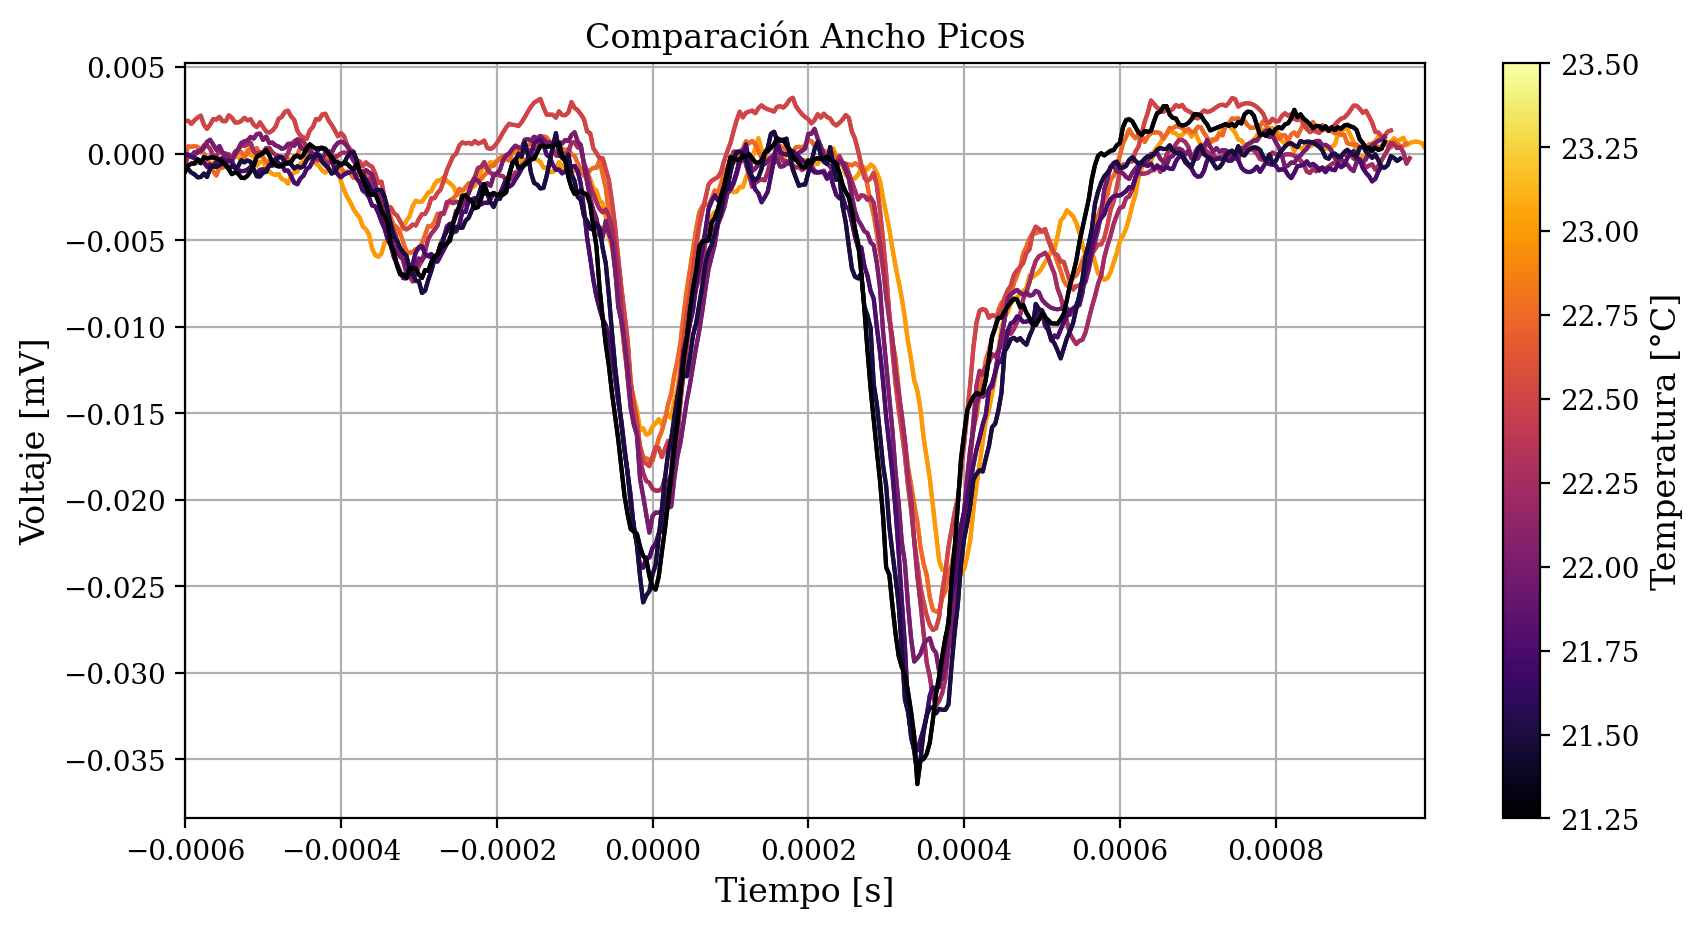

In [40]:
norm = Normalize(Temps_arr.min(), Temps_arr.max())  # Un normalizador que asocia valores del intervalo de n al rango [0:1].
warmscale = plt.cm.ScalarMappable(norm, 'inferno', )  # Asocio los valores del rango de n normalizado en [0:1] a una paleta de colores.
colors2 = warmscale.to_rgba  # la función que dado n devuelve el color asociado

plt.figure(figsize=(10, 5))
plt.title(f'Comparación Ancho Picos')
plt.xlabel(f'Tiempo [s]')
plt.ylabel(f'Voltaje [{v_units}V]')
plt.grid()

for i in range(7, -1, -1):
    t = t_[i] 
    v = v_[i]
    n = i_[i]
    plt.plot(t[peaks[n][0] - 150: peaks[n][1] + 150] - t[peaks[n][0]],
             v[peaks[n][0]-150: peaks[n][1]+150],
            #  label=f'{Temps_arr[i][0]}°C',
             c=colors2(Temps_arr[i][0]),
             )
# plt.legend()
# plt.show()

# plt.figure(figsize=(10, 5))
# plt.title(f'Comparación Ancho Picos')
# plt.xlabel(f'Tiempo [s]')
# plt.ylabel(f'Voltaje [{v_units}V]')
# plt.grid()

# for i in range(4, 8):
#     t = t_[i] 
#     v = v_[i]
#     n = i_[i]
    plt.plot(t[peaks[n][0] - 150: peaks[n][1] + 150] - t[peaks[n][0]],
             v[peaks[n][0]-150: peaks[n][1]+150],
            #  label=f'{Temps_arr[i][0]}°C',
             c=colors2(Temps_arr[i][0]),
             )
# plt.legend()
plt.colorbar(warmscale, label="Temperatura [°C]")
plt.show()

In [ ]:
plt.plot(Temps_arr[:, 0], anchos_tiempo, '.--', mec="k", mew=0.75,)
plt.xlabel("Temperaturas [°C]")
plt.ylabel(f"Ancho de los picos [s]")
plt.grid()
plt.show()

for i, temp in enumerate(Temps_arr[:, 0]):
    print(f'\nLos anchos encontrados para la temperatura {temp} °C fueron:\nPico 1°: {anchos_tiempo[i][0]:.3g} s\nPico 2°: {anchos_tiempo[i][1]:.3g} s\n')

In [ ]:
anchos_frecs = [] #GHz
f_ = []
v_ = []
i_ = []
for i in range(len(freqs_arr)):
    a, f, v, i = ancho_pico(freqs_arr, V1, peaks, i)
    f_.append(f)
    v_.append(v)
    i_.append(i)
    anchos_tiempo.append(a)

In [ ]:
plt.figure(figsize=(10, 5))
plt.title(f'Comparación Ancho Picos')
plt.xlabel(f'Frecuencia Relativa [GHz]')
plt.ylabel(f'Voltaje [{v_units}V]')
plt.grid()

for i in range(4):
    f = f_[i] 
    v = v_[i]
    n = i_[i]
    plt.plot(f[peaks[n][0] - 150: peaks[n][1] + 150] - f[peaks[n][0]],v[peaks[n][0]-150: peaks[n][1]+150], label=f'{Temps_arr[i][0]}°C')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.title(f'Comparación Ancho Picos')
plt.xlabel(f'Frecuencia Relativa [GHz]')
plt.ylabel(f'Voltaje [{v_units}V]')
plt.grid()

for i in range(4, 8):
    f = f_[i] 
    v = v_[i]
    n = i_[i]
    plt.plot(f[peaks[n][0] - 150: peaks[n][1] + 150] - f[peaks[n][0]],v[peaks[n][0]-150: peaks[n][1]+150], label=f'{Temps_arr[i][0]}°C')
plt.legend()

In [ ]:
plt.plot(Temps_arr[:, 0], anchos_frecs, '.--', mec="k", mew=0.75,)
plt.xlabel("Temperaturas [°C]")
plt.ylabel(f"Ancho de los picos [{f_units}Hz]")
plt.grid()
plt.show()

for i, temp in enumerate(Temps_arr[:, 0]):
    print(f'\nLos anchos encontrados para la temperatura {temp} °C fueron:\nPico 1°: {anchos_frecs[i][0]:.3g} {f_units}Hz\nPico 2°: {anchos_frecs[i][1]:.3g} {f_units}Hz\n')
